## Setup

In [10]:
import os
import hashlib
import pickle
import json
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Ant Colony Optimization for Specific Sequence of Districts

In [2]:
random_seed = 12  # Group 12

g = nx.read_gml("graphs/seidel_rally_graph-12_filtered.gml")
g.nodes

NodeView(('Weinstadt', 'Klub Gru', 'Glashütte', 'Das Torberg', 'Mokador 8', 'u.s.w.', 'Pub by Charles', 'Hopfen-Stuben', 'Café Amadeus', 'Acabar', 'Ganz Wien', 'Café 7*stern', 'Kerstin', 'Prater Dome', 'Zum Schlauch', 'Oskar', 'Bastille-Pub', 'Gasthaus Manu', 'Schlupfwinkel', 'Wiener Blut', 'Cafe Nest', 'Derwisch', 'Wirr am Brunnenmarkt', 'Weberknecht', "Wind & Mill's", 'Miranda', 'Top Kino Bar', 'Rendezvous', 'Mimi im Stadtelefant', "Guggi's Beisl", 'Azul Bar', 'Casablanca', 'Slammerbar', 'Red Lion', "'s Stammbeisl", 'Bar Black Lounge', 'Café Frog', 'Gimlet', 'Remi Demi', 'Espresso Slatki San', 'Gerüchteküche', 'Espresso Karawane', "Karin's Radlertreff", 'SLU-Bar', 'Unders', 'Couch Potato', "Steiner's Club Lounge", 'K.St.V. Rhaetia', 'Schaumweinhäuschen', 'Schneider-Gössl Sektbar', 'Kleine Ober St. Veiter Bierstube', "Gaby's Treff", 'Biergartl', 'The Twinspub', 'Flokal', "Wistl's Cafe", "Otti's Würstel Bar", 'Hinteralm', 'Cafe Liquid', 'The Little Stage', 'Stammersdorfer Hauptprostamt

## Modify the Graph
We have couple of constraints for this problem. First of all the order of the districts, that we start with district 23 and end in district 1, this is provided with the filtered graph structure, since each pub only has a connection to its neighboring district. Additionally by adding an artificial start and end node, the algorithm boils down to a simple shortest path computation.

In [3]:
def construct_instance(g):
    # Add start and end node
    g.add_node('start')
    g.nodes['start']['district'] = float('inf')
    g.add_node('end')
    g.nodes['end']['district'] = float('-inf')
    
    # Connect start and end node to graph
    first_district_pubs = [n for n, attr in g.nodes(data=True) if attr['district'] == 1]
    last_district_pubs = [n for n, attr in g.nodes(data=True) if attr['district'] == 23]
    for node in last_district_pubs:
        g.add_edge('start', node, weight=0)
    
    for node in first_district_pubs:
        g.add_edge(node, 'end', weight=0)
    
    # Construct directed graph
    dg = nx.DiGraph()
    for u, v, attr in g.edges(data=True):
        if g.nodes[u]['district'] > g.nodes[v]['district']:
            dg.add_edge(u, v, weight=attr['weight'])
        else:
            dg.add_edge(v, u, weight=attr['weight'])
    
    return dg

In [4]:
dg = construct_instance(g)

## Optimal Solution

In [5]:
def print_path(path, titel):
    path_weight = nx.path_weight(dg, path, weight='weight')
    print(f"{titel} ({path_weight}):")
    for v in path:
        district = g.nodes[v]['district']
        print(f"{v}, {district}")

def find_optimal_route(dg):
    shortest_path = nx.shortest_path(dg, source='start', target='end', weight='weight')
    return shortest_path[1:-1], nx.path_weight(dg, shortest_path, weight='weight')

opt_path, opt_length = find_optimal_route(dg)
print_path(opt_path, "The Optimal Solution")

The Optimal Solution (23035.0):
Köö Billardcafe, 23.0
Otti's Würstel Bar, 22.0
Star Voice Lounge, 21.0
Couch Potato, 20.0
SLU-Bar, 19.0
Gasthaus Manu, 18.0
Espresso Karawane, 17.0
Derwisch, 16.0
Pub by Charles, 15.0
Biergartl, 14.0
Schaumweinhäuschen, 13.0
Golden Harp Kaffeehaus, 12.0
Café Frog, 11.0
Mimi im Stadtelefant, 10.0
Klub Gru, 9.0
Das Torberg, 8.0
Ganz Wien, 7.0
Wind & Mill's, 6.0
Cafe Liquid, 5.0
Cafe Nest, 4.0
's Stammbeisl, 3.0
Kerstin, 2.0
Casablanca, 1.0


## The ACO Algorithm

In [6]:
iterations = 100
ants = 100
pheromone_evaporation_rate = 0.1
pheromone_deposit = 1.0
alpha = 1  # Pheromone influence
beta = 1   # Heuristic influence

In [7]:
import itertools
from tqdm import tqdm
def aco_find_best_route(dg):
    np.random.seed(random_seed)
    potential_transition_edges = {v : dg.out_edges(v) for v in g.nodes()}
    potential_transition_nodes = {v : [o for i, o in potential_transition_edges[v]] for v in g.nodes()}
    desirability_of_edge = {(u, v) : 1/attr['weight'] if attr['weight'] != 0 else 1 for u, v, attr in dg.edges(data=True)}
    pheromones_of_edge = {(u, v) : 1 for u, v in dg.edges()}

    def filtered_choose_next_node(current_node):
        probs = np.array([alpha*pheromones_of_edge[e]+beta*desirability_of_edge[e] for e in potential_transition_edges[current_node]])
        probs = probs / probs.sum()
        return np.random.choice(potential_transition_nodes[current_node], p=probs)
    
    best_path = []
    best_length = float('inf')
    best_paths = []
    best_lengths = []
    
    for i in (pbar := tqdm(range(iterations), total=iterations, desc="Running ACO: ")):
        all_paths = []
        all_path_lengths = []
    
        # Run each ant
        for ant in range(ants):
            current_node = 'start'
            path = [current_node]
            while current_node != 'end':
                next_node = filtered_choose_next_node(current_node)
                path.append(next_node)
                current_node = next_node
            all_paths.append(path)
            all_path_lengths.append(nx.path_weight(dg, path, weight='weight'))
    
        # Pheromone Evaporation
        for e in dg.edges():
            pheromones_of_edge[e] = (1 - pheromone_evaporation_rate) * pheromones_of_edge[e]
            
        # Pheromone Deposit
        for path, length in zip(all_paths, all_path_lengths):
            if length < best_length:
                best_path = path
                best_length = length
                pbar.set_description(f"Current Best Solution: {best_length}")
            pheromone_to_add = pheromone_deposit / length
            for i in range(len(path) - 1):
                pheromones_of_edge[(path[i], path[i + 1])] += pheromone_to_add

        best_paths.append(best_path[1:-1])
        best_lengths.append(best_length)
    
    return best_paths, best_lengths

best_paths, best_lengths = aco_find_best_route(dg)
print_path(best_paths[-1], "The Best Solution Found")

Current Best Solution: 25244.0: 100%|██████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.21it/s]

The Best Solution Found (25244.0):
genussbar, 23.0
Otti's Würstel Bar, 22.0
Star Voice Lounge, 21.0
Couch Potato, 20.0
SLU-Bar, 19.0
Gasthaus Manu, 18.0
Espresso Slatki San, 17.0
Derwisch, 16.0
Pub by Charles, 15.0
Biergartl, 14.0
Schaumweinhäuschen, 13.0
das Hugo, 12.0
Café Frog, 11.0
Rendezvous, 10.0
Weinstadt, 9.0
u.s.w., 8.0
Acabar, 7.0
Wind & Mill's, 6.0
Cafe Liquid, 5.0
Schlupfwinkel, 4.0
's Stammbeisl, 3.0
Prater Dome, 2.0
Casablanca, 1.0


## Generate Solutions for all Test Graphs

In [8]:
def generate_hash(*args):
    hash_object = hashlib.md5(str(args).encode())  # Using MD5 for simplicity
    return hash_object.hexdigest()

hyperparameters = {
    'iterations': iterations,
    'ants': ants,
    'pheromone_evaporation_rate': pheromone_evaporation_rate,
    'pheromone_deposit': pheromone_deposit,
    'alpha': alpha,
    'beta': beta
}

hash_name = generate_hash(iterations, ants, pheromone_evaporation_rate, pheromone_deposit, alpha, beta)
hyperparameters_file_path = f"aco_results/hyperparameters_aco_results_{hash_name}.json"
with open(hyperparameters_file_path, 'w') as f:
    json.dump(hyperparameters, f, indent=4)
    
for i in range(1, 11):
    g = nx.read_gml(f"graphs/seidel_rally_graph-{i}_filtered.gml")
    dg = construct_instance(g)
    result_file_path = f"aco_results/seidel_rally_graph-{i}_aco_results_{hash_name}.pkl"
    if not os.path.exists(result_file_path):
        best_paths, best_lengths = aco_find_best_route(dg)
        with open(result_file_path, 'wb') as f:
            pickle.dump((best_paths, best_lengths), f)

Current Best Solution: 27019.0: 100%|██████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.49it/s]


## Plot Results

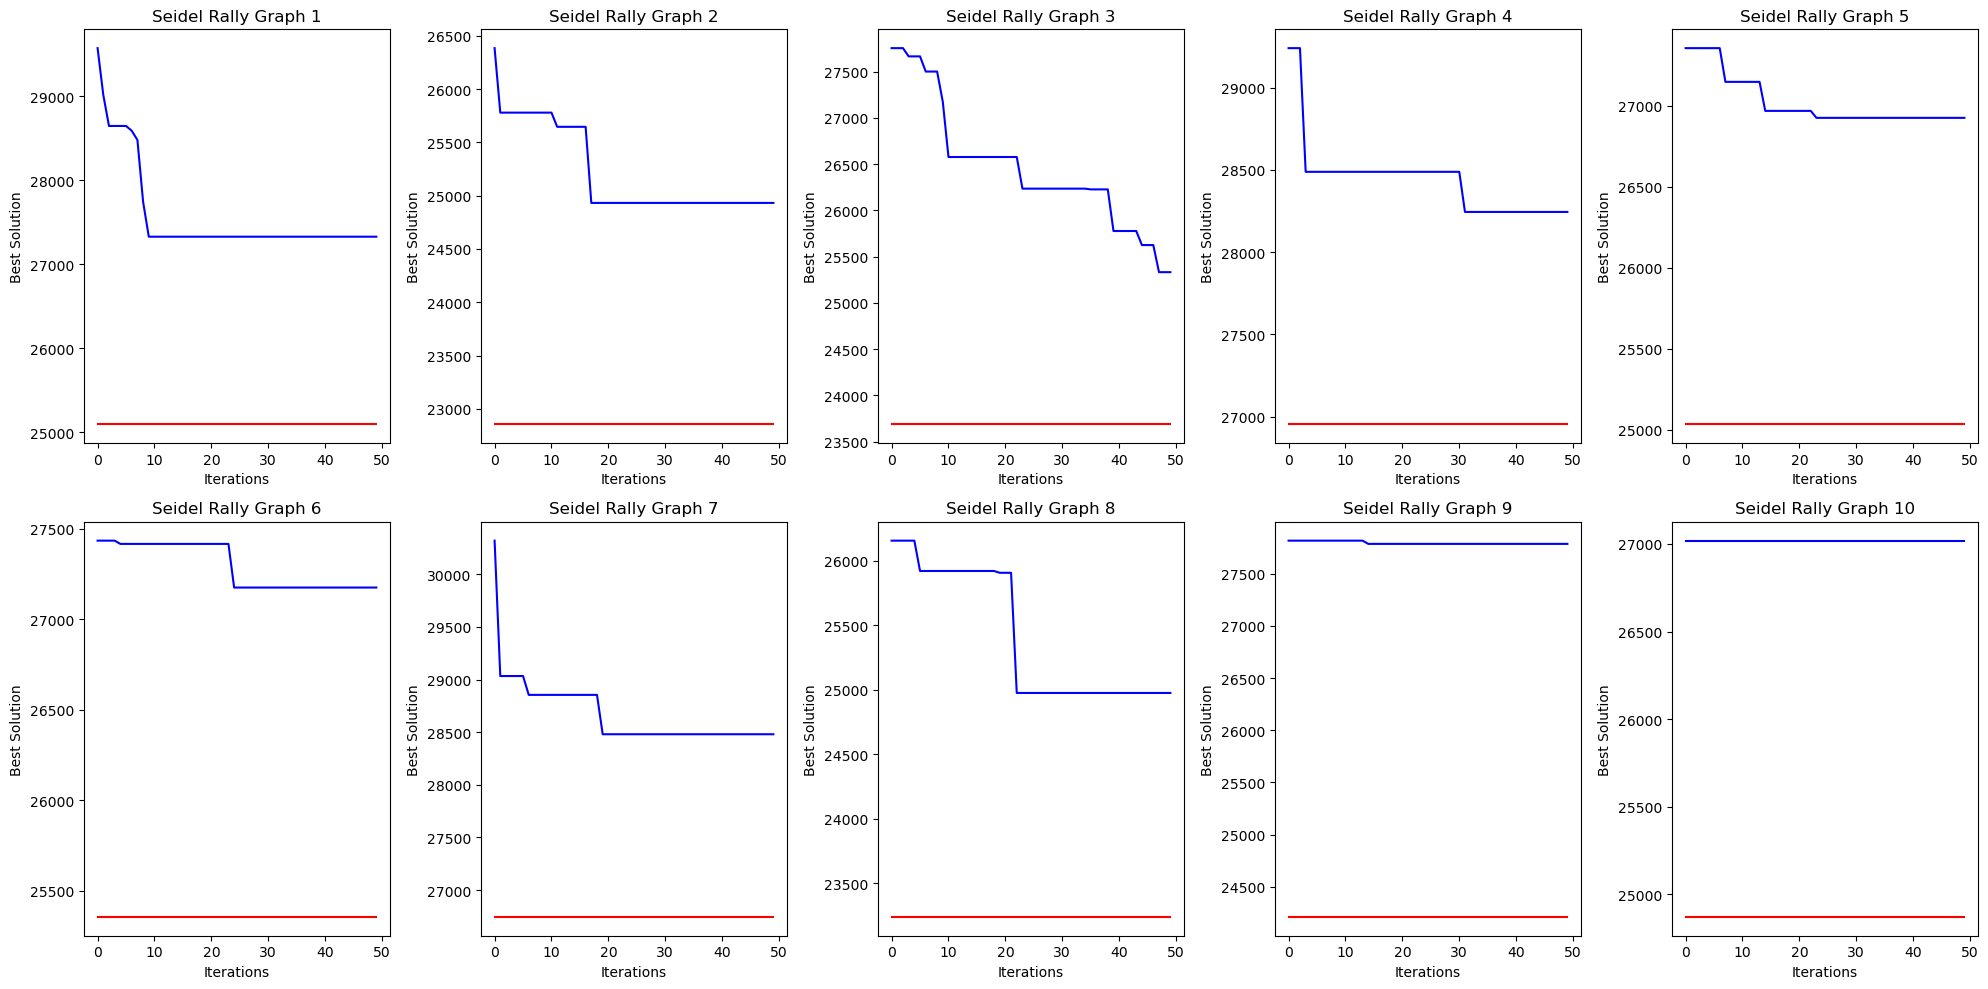

In [9]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()

hash_name = generate_hash(iterations, ants, pheromone_evaporation_rate, pheromone_deposit, alpha, beta)
for i in range(1, 11):
    g = nx.read_gml(f"graphs/seidel_rally_graph-{i}_filtered.gml")
    dg = construct_instance(g)
    opt_path, opt_length = find_optimal_route(dg)
    
    file_path = f"aco_results/seidel_rally_graph-{i}_aco_results_{hash_name}.pkl"
    with open(file_path, 'rb') as f:
        best_paths, best_lengths = pickle.load(f)

    x = np.arange(iterations)
    axes[i-1].plot(x, best_lengths, label="ACO", color='blue')
    axes[i-1].plot(x, [opt_length] * iterations, label="Optimal", color='red')
    
    # Add labels and title
    axes[i-1].set_xlabel("Iterations")
    axes[i-1].set_ylabel("Best Solution")
    axes[i-1].set_title(f"Seidel Rally Graph {i}")
    
# Show the plot
plt.tight_layout()
plt.savefig("aco_results.png", format='png')
plt.show()